<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip3 install

In [1]:
!pip3 install scikit-image

# import

In [3]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

# Load kitti dataset

In [121]:
if "2011_09_26_drive_0020_sync.zip" not in os.listdir():
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
  !unzip  2011_09_26_drive_0020_sync.zip >/dev/null

dataset_dir = "./2011_09_26/2011_09_26_drive_0020_sync/image_02"
imgs_dir = os.path.join(dataset_dir, "data")
timestamps_file_path = os.path.join(dataset_dir, "timestamps.txt")

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
kitti_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

# Features utils

In [117]:
class FundamentalMatrixTransform():
  def __init__(self):
    self.F = np.eye(3)

  def estimate(self, kps_tn1, kps_t):
    # Setup constraint matrix
    A = np.column_stack((
      kps_tn1[:,0] * kps_t[:,0],
      kps_tn1[:,0] * kps_t[:,1],
      kps_tn1[:,0],
      kps_tn1[:,1] * kps_t[:,0],
      kps_tn1[:,1] * kps_t[:,1],
      kps_tn1[:,1],
      kps_t[:,0],
      kps_t[:,1],
      np.ones(len(kps_tn1)),
    ))

    # Solve for nullsapce of the constraint matrix
    u, s, vt = np.linalg.svd(A)
    F = vt[-1,:].reshape(3,3)

    # Enforcing Rank 2
    u, s, vt = np.linalg.svd(F)
    s[2] = 0
    self.F = u @ np.diag(s) @ vt

    return True

  def residuals(self, kps_tn1, kps_t):
    # point-to-epipolar line distance
    # suffix underscore indicate homogeneous coordimate
    kps_tn1_ = np.column_stack([kps_tn1, np.ones(kps_tn1.shape[0])])
    kps_t_ = np.column_stack([kps_t, np.ones(kps_t.shape[0])])

    e_tn1 = kps_t_ @ self.F.T  # Epipilar line on tn1 image
    e_t = kps_tn1_ @ self.F  # Epipilar line on t image
    
    residue = (kps_tn1_ * e_tn1).sum(axis = 1) # Residue from coplanarity constraint

    return np.abs(residue) / np.sqrt(e_tn1[:,0]** 2 + e_tn1[:,1]** 2
                                     + e_t[:,0]** 2 + e_t[:,1]** 2)

In [118]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=1000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des


def match_features(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf_matcher.match(des_tn1, des_t)
  return np.array([[match.queryIdx, match.trainIdx] for match in matches])

def match_features2(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des_tn1, des_t, k=2)

  idx_tn1, idx_t = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance < 0.75 * m2.distance:
      if m1.distance < 32:
        if m1.trainIdx not in idx_t:
          idx_tn1.append(m1.queryIdx)
          idx_t.append(m1.trainIdx)

  assert len(idx_tn1) >= 8, f"#matches: {len(idx_tn1)}" 
  return np.array([idx_tn1, idx_t]).T

# Main

#kps_tn1: 1000 #kps_t: 1000
(226, 2)
#matches: 226


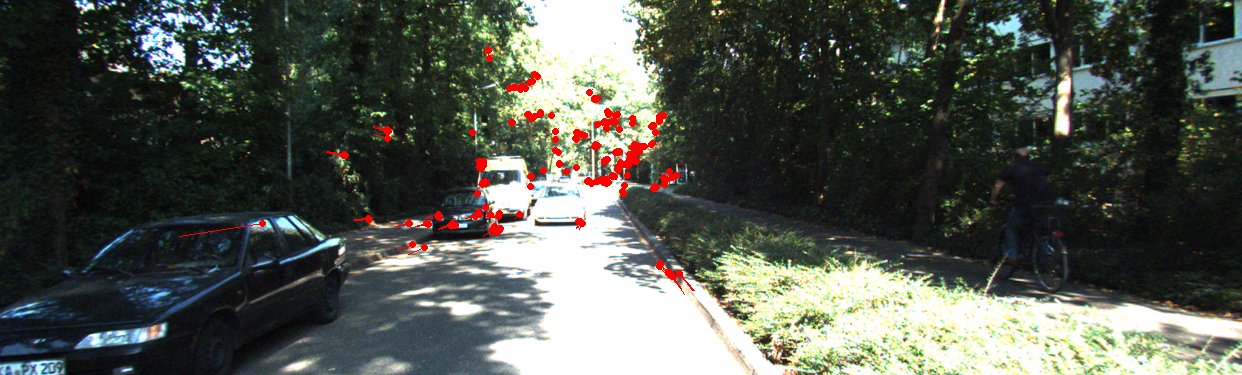

In [135]:
tn1 = 20
t = 25
img_tn1 = kitti_imgs[tn1]
img_t = kitti_imgs[t]

kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_tn1: {len(kps_tn1)} #kps_t: {len(kps_t)}")

matches = match_features2(des_tn1, des_t)
print(matches.shape)
print(f"#matches: {len(matches)}")

# disp_img = cv2.drawKeypoints(img_tn1, [cv2.KeyPoint(kp_tn1[0], kp_tn1[1], 0) for kp_tn1 in kps_tn1], 0, (255, 0, 0))
disp_img = img_tn1.copy()
for match in matches:
  start_point = tuple(kps_tn1[match[0]])
  end_point = tuple(kps_t[match[1]])
  disp_img = cv2.circle(disp_img, start_point, 2, (0, 0, 255), 2)
  disp_img = cv2.line(disp_img, start_point, end_point, (0, 0, 255), 1)
cv2_imshow(disp_img)

# img_match = cv2.drawMatches(
#     img_tn1, [cv2.KeyPoint(kp_tn1[0], kp_tn1[1], 0) for kp_tn1 in kps_tn1],
#     img_t, [cv2.KeyPoint(kp_t[0], kp_t[1], 0) for kp_t in kps_t],
#     [cv2.DMatch(match[0], match[1], 0) for match in matches],
#     None,
#     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
# )
# cv2_imshow(img_match)

# fundamental_matrix_transform, inliers = ransac(
#   (kps_tn1[matches[:,0]], kps_tn1[matches[:,0]]),
#   FundamentalMatrixTransform,
#   min_samples=8,
#   residual_threshold=1e-15,
#   max_trials=500
# )
# matches = matches[inliers]
# print(f"#matches_inliers: {len(matches)}")

# img_match = cv2.drawMatches(
#     img_tn1, [cv2.KeyPoint(kp_tn1[0], kp_tn1[1], 0) for kp_tn1 in kps_tn1],
#     img_t, [cv2.KeyPoint(kp_t[0], kp_t[1], 0) for kp_t in kps_t],
#     [cv2.DMatch(match[0], match[1], 0) for match in matches],
#     None,
#     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
# )
# cv2_imshow(img_match)

# Play with RANSAC from scikit-learn

In [ ]:
!pip3 install scikit-image

In [ ]:
from skimage.measure import ransac
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Line2D():
  def __init__(self):
    # 2d line is modeled as y = ax + b
    self.a = 0.0
    self.b = 0.0

  def estimate(self, data):
    """
    Args:
      data: numpy array of shape (N,2)
    Returns:
      True or False based on whether model was estimated successfully.
    """
    N = len(data)
    assert N >= 2, "Under determined system!"

    A = np.vstack((
      data[:,0],
      np.ones(N)
    )).T
    b = data[:,1]
    try:
      self.a, self.b = np.linalg.inv(A.T @ A) @ A.T @ b
      return True
    except np.linalg.LinAlgError:
      return False

  def residuals(self, data):
    """
    Args:
      data: numpy array of shape (N,2)
    Returns:
      numpy array of shape (N,) representing the residue for each data point
    """
    return (self.a * data[:,0] - data[:,1] + self.b)**2 / (self.a**2 + 1)
  
  def predict_y(self, x):
    return self.a * x + self.b

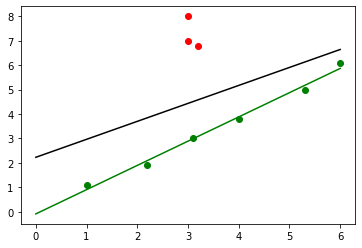

In [ ]:
inlier = np.array([[1,1.1],[2.2,1.9],[3.1,3],[4,3.8],[5.3,5], [6,6.1]])
outlier = np.array([[3,7],[3.2,6.8],[3,8]])
data = np.vstack((inlier, outlier))
plt.scatter(inlier[:,0], inlier[:,1], color='green')
plt.scatter(outlier[:,0], outlier[:,1], color='red')

model = Line2D()
model.estimate(data)

plt.plot(np.arange(7), model.predict_y(np.arange(7)), color='black')

model_robust, inlier_est = ransac(
  data,
  Line2D,
  min_samples=2,
  residual_threshold=0.4,
  max_trials=100
)

plt.plot(np.arange(7), model_robust.predict_y(np.arange(7)), color='green')

# Docs

## Track Progress

### Day 1
#### TODO
- Understand ORB feature detector.
    (image) --|ORB|--> keypoints & descriptor
#### Done
ORB: (Oriented FAST) + (Rotated BRIEF)

- Understood how FAST and BRIEF works
- Understood modification of FAST in ORB
- Used ORB from cv2 to detect and display keypoints and Understood the mapping
  between input and output to ORB.

### Day 2
#### TODO
- Understand the ORB descriptor given the keypoint.
- And verify it with the cv2 ORB implementation.
- Feature matching, RENSAC and vo with ORB.
#### Done
- Understood ORB detector and descriptor and verified it with cv2 implementation.
- Understood brute force feature matchinga and verified with cv2.

### Day 3
#### TODO
- Read Tutorial 1:
    - Formulation of the VO Problem
    - Camera Modeling and Calibration
    - Motion Estimation
#### Done
- Understood Formulation of the VO Problem, Camera Modeling and Calibration.
- Stuck at Motion Estimation (What is Fundamental and Essential Matrices?)

### Day 4
#### TODO
- Understand Essential and Fundamental Matrices.
- Read DF-VO: What Should Be Learnt for Visual Odometry?

#### Done
- Understood Essential and Fundamental Matrices.
- Read DF-VO Introduction

### Day 5
#### TODO
- Read about ORB SLAM.

### Some Day
- Use RANSAC to obtain corrospending ORB features in image pair.
- Use corrospending ORB features in image pair and calibration matrix to obtain essential matrix.

## README

### Visual Odometry

(Camera data stream) --|Visual Odometry|--> (Camera Pose over time)

**Approach:** ORB Feature based Monocular Visual Odometry

**Dataset:** [ICL Dataset](https://peringlab.org/lmdata/)

#### Reference
1. [geohotz twitchslam](https://github.com/geohot/twitchslam)
2. [ORB: An efficient alternative to SIFT or SURF](https://github.com/commaai/rednos://ieeexplore.ieee.org/abstract/document/6126544)
3. [Introduction to ORB (Oriented FAST and Rotated BRIEF): Medium Post](https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
4. [SVO: Fast Semi-Direct Monocular Visual Odometry](https://www.zora.uzh.ch/id/eprint/125453/1/ICRA14_Forster.pdf)
5. Visual Odometry Tutorial
    2. [Visual Odometry (Part 1): The First 30 Years and Fundamentals](https://www.alaakhamis.org/teaching/SPC418/reading/Visual%20odometry.pdf)
    3. [Visual Odometry (Part 2): Matching, Robustness, Optimization, and Applications](https://www.zora.uzh.ch/id/eprint/71030/1/Fraundorfer_Scaramuzza_Visual_odometry.pdf)